## Algorithmic Trading: Mean Reversion 

### Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import datetime
import back_testing as bt
import yfinance as yf

### Get Data

In [2]:
df0 = yf.download('HEROMOTOCO.NS', start='2019-01-01')

[*********************100%***********************]  1 of 1 completed


In [3]:
df = df0.reset_index()
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-01-01,3089.000000,3135.000000,3073.300049,3127.600098,2737.405518,344239
1,2019-01-02,3115.000000,3117.300049,3023.800049,3046.550049,2666.466797,597712
2,2019-01-03,3032.000000,3078.000000,3006.300049,3014.649902,2638.546875,368413
3,2019-01-04,3030.000000,3045.000000,2972.050049,2987.850098,2615.090576,405667
4,2019-01-07,3020.000000,3023.000000,2952.000000,2957.949951,2588.920410,361881
...,...,...,...,...,...,...,...
903,2022-08-26,2835.000000,2840.899902,2817.050049,2826.750000,2826.750000,475372
904,2022-08-29,2788.899902,2831.949951,2761.100098,2827.050049,2827.050049,339203
905,2022-08-30,2842.000000,2864.000000,2831.550049,2837.699951,2837.699951,918526
906,2022-09-01,2820.000000,2882.199951,2792.899902,2876.649902,2876.649902,838699


In [4]:
#Rename cols
df = df.rename({'Date': 'date','Open': 'open','High': 'high','Low': 'low','Close': 'close','Adj Close': 'adjusted_close','Volume': 'volume'
},axis=1)

In [5]:
df

,date,open,high,low,close,adjusted_close,volume
0,2019-01-01,3089.000000,3135.000000,3073.300049,3127.600098,2737.405518,344239
1,2019-01-02,3115.000000,3117.300049,3023.800049,3046.550049,2666.466797,597712
2,2019-01-03,3032.000000,3078.000000,3006.300049,3014.649902,2638.546875,368413
3,2019-01-04,3030.000000,3045.000000,2972.050049,2987.850098,2615.090576,405667
4,2019-01-07,3020.000000,3023.000000,2952.000000,2957.949951,2588.920410,361881
...,...,...,...,...,...,...,...
903,2022-08-26,2835.000000,2840.899902,2817.050049,2826.750000,2826.750000,475372
904,2022-08-29,2788.899902,2831.949951,2761.100098,2827.050049,2827.050049,339203
905,2022-08-30,2842.000000,2864.000000,2831.550049,2837.699951,2837.699951,918526
906,2022-09-01,2820.000000,2882.199951,2792.899902,2876.649902,2876.649902,838699


### Calculate ma

In [6]:
#Short moving averages (5-20 periods) are best suited for short-term trends and trading
df['ma_200'] = df['close'].rolling(200).mean()

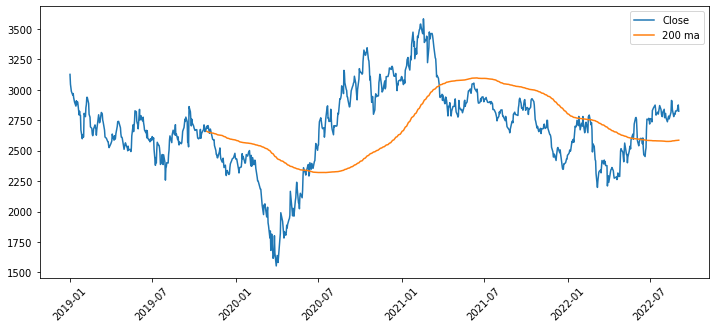

In [7]:
#plot for validation
plt.figure(figsize=(12,5))
plt.xticks(rotation=45)

plt.plot(df['date'], df['close'], label = 'Close')
plt.plot(df['date'], df['ma_200'], label = '200 ma')

plt.legend()
plt.show()

### Calculate Bollinger Bands

In [8]:
period = 20

#Calculate 20-ma and std dev
df['ma_20'] = df['close'].rolling(period).mean()
df['std'] = df['close'].rolling(period).std()

#Calculate bollinger bands using std dev
df['upper_bollinger'] = df['ma_20'] + (2 * df['std'])
df['lower_bollinger'] = df['ma_20'] - (2 * df['std'])

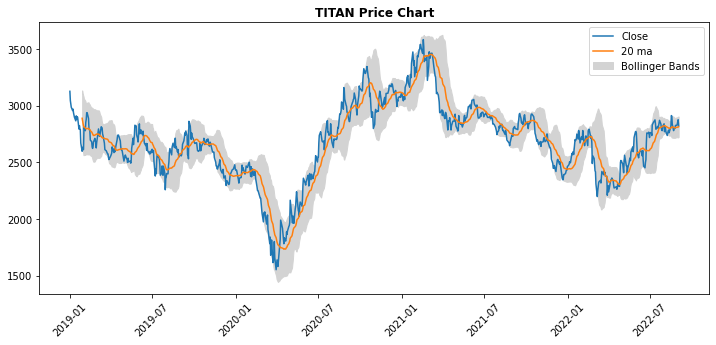

In [9]:
#plot for validation
plt.figure(figsize=(12,5))
plt.xticks(rotation=45)

x_axis = df['date']

plt.plot(x_axis, df['close'], label = 'Close')
plt.plot(df['date'], df['ma_20'], label = '20 ma')
plt.fill_between(x_axis, df['upper_bollinger'], df['lower_bollinger'], label = 'Bollinger Bands', color='lightgrey')

plt.title('TITAN Price Chart', fontweight="bold")
plt.legend()
plt.show()

### Calculate RSI

In [10]:
def gain(value):
    if value < 0:
        return 0
    else:
        return value

In [11]:
def loss(value):
    if value > 0:
        return 0
    else:
        return abs(value)

In [12]:
period = 6

#Calculate price delta
df['delta'] = df['close'].diff()

#Classify delta into gain & loss
df['gain'] = df['delta'].apply(lambda x:gain(x))
df['loss'] = df['delta'].apply(lambda x:loss(x))

#Calculate ema 
df['ema_gain'] = df['gain'].ewm(period).mean()
df['ema_loss'] = df['loss'].ewm(period).mean()

#Calculate RSI
df['rs'] = df['ema_gain']/df['ema_loss']
df['rsi'] = df['rs'].apply(lambda x: 100 - (100/(x+1)))

(0.0, 100.0)

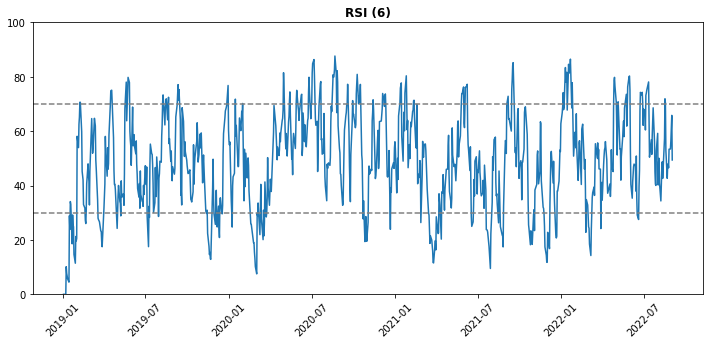

In [13]:
#plot for validation
plt.figure(figsize=(12,5))
plt.xticks(rotation=45)

x_axis = df['date']

plt.plot(x_axis, df['rsi'])
plt.axhline(30, c= (.5,.5,.5), ls='--')
plt.axhline(70, c= (.5,.5,.5), ls='--')

plt.title('RSI (6)', fontweight="bold")
plt.ylim([0, 100])

### Implementing buy/sell

#### Rules:
    1. Buy when 10-period RSI below 30 (buy next day) & Price below lower bollinger band
    2. Sell when 10-period RSI above 70 (sell next day) & Price above upper bollinger band

In [14]:
#buy signal
df['signal'] = np.where(
    (df['rsi'] < 30) &
    (df['close'] < df['lower_bollinger']), 1, np.nan)

#sell signal
df['signal'] = np.where(
    (df['rsi'] > 70) & 
    (df['close'] > df['upper_bollinger']), -1, df['signal'])

#buy/sell next trading day
df['signal'] = df['signal'].shift()
df['signal'] = df['signal'].fillna(0)

### Backtesting Strategy

In [15]:
bt.backtest_dataframe(df)

Buying at 2633.300048828125 on 2019-01-29 00:00:00
Selling at 2741.550048828125 on 2019-04-18 00:00:00
Buying at 2444.10009765625 on 2019-07-09 00:00:00
Selling at 2740.75 on 2019-09-12 00:00:00
Buying at 2502.89990234375 on 2019-11-18 00:00:00
Selling at 2000.699951171875 on 2020-05-04 00:00:00
Buying at 2911.949951171875 on 2020-10-27 00:00:00
Selling at 3248.25 on 2021-01-12 00:00:00
Buying at 3350.199951171875 on 2021-03-01 00:00:00
Selling at 2991.550048828125 on 2021-05-28 00:00:00
Buying at 2838.25 on 2021-07-22 00:00:00
Selling at 2932.10009765625 on 2021-09-17 00:00:00
Buying at 2744.14990234375 on 2021-10-22 00:00:00
Selling at 2568.25 on 2022-01-11 00:00:00
Buying at 2558.39990234375 on 2022-02-25 00:00:00
Selling at 2517.300048828125 on 2022-04-28 00:00:00

Evaluation Metrics:
-----------------------------------
Number of Trades: 8
Number of Gains: 4
Number of Losses: 4
Total Returns: -11.57%
Win Rate: 50.0%
Average Gain: 7.78%
Average Loss: -9.7%
Max Return: 12.14%
Max Los

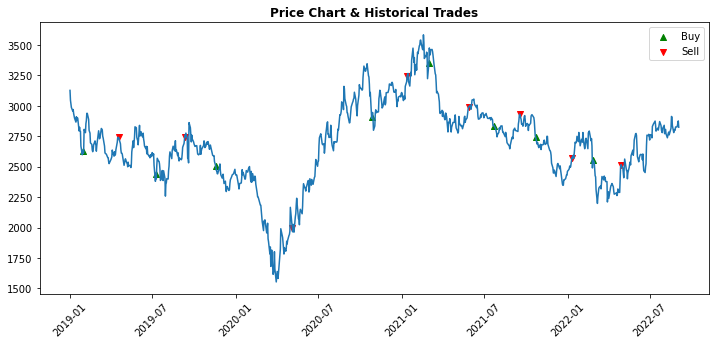

In [16]:
plt.figure(figsize=(12,5))
plt.xticks(rotation=45)

plt.plot(df['date'], df['close'])
plt.scatter(df[(df['signal'] == 1)]['buy_date'], df[(df['signal'] == 1)]['close'], label = 'Buy', marker='^', c='g')
plt.scatter(df[(df['signal'] == -1)]['sell_date'], df[(df['signal'] == -1)]['close'], label = 'Sell', marker='v', c='r')

plt.title('Price Chart & Historical Trades', fontweight="bold")
plt.legend()
plt.show()